In [17]:
!pip install --upgrade numpy==1.26.4


In [18]:
!pip install opencv-python-headless==4.10.0.84


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.0/38.8 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.0/38.8 MB 281.8 kB/s eta 0:02:18
   ---------------------------------------- 0.1/38.8 MB 393.8 kB/s eta 0:01:39
   ---------------------------------------- 0.1/38.8 MB 554.9 kB/s eta 0:01:10
   ---------------------------------------- 0.1/38.8 MB 568.9 kB/s eta 0:01:08
   ---------------------------------------- 0.2/38.8 MB 687.0 kB/s eta 0:00:57
   ---------------------------------------- 0.3/38.8 MB 744.2 kB/s eta 0:00:52
   ---------------------------------------- 0.3/38.8 MB 731.4 kB/s eta 0:00:53
   ---------------------------------------- 0.4/38.8 MB 859.0 kB/s eta 0:00:45
    --------------------------------------- 0.5/38.8 MB 1.0 MB/s eta 0:00:39
    --------------------------------------- 0.6/38.8 MB 1.1 MB/

  You can safely remove it manually.


In [23]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split


In [22]:
!pip install tensorflow


  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.7 M

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.1 which is incompatible.


In [24]:
zip_path = "/content/Aerial_Landscapes.zip"
extract_path = "/content/Aerial_Landscapes"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("📁 Folders inside the dataset:")
print(os.listdir(extract_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/Aerial_Landscapes.zip'

In [ ]:
folders = os.listdir(main_folder)
print("📂 Folders inside the dataset:")
print(folders)

📂 Folders inside the dataset:
['Forest', 'Port', 'Airport', 'Lake', 'Highway', 'Beach', 'Grassland', 'River', 'Residential', 'Agriculture', 'Mountain', 'Parking', 'Desert', 'Railway', 'City']


# **Data Pre-Processing**

In [ ]:
image_dir = "/content/desert_agri_dataset/images"
mask_dir  = "/content/desert_agri_dataset/masks"
image_size = (128, 128)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img / 255.0
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size)

    mask_bin = (mask >= 128).astype(np.float32)
    mask_bin = np.expand_dims(mask_bin, axis=-1)
    return mask_bin

# **Pre-Processing Masks**

In [ ]:
image_files = sorted(os.listdir(image_dir))
mask_files  = sorted(os.listdir(mask_dir))

images = np.array([preprocess_image(os.path.join(image_dir, f)) for f in image_files], dtype=np.float32)
masks  = np.array([preprocess_mask(os.path.join(mask_dir, f)) for f in mask_files], dtype=np.float32)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (1600, 128, 128, 3)
Masks shape: (1600, 128, 128, 1)


# **Train / Test Spilt**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8).shuffle(100)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)

# **Model Selection**

In [ ]:

def simple_unet(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)


    c1 = layers.Conv2D(16,3,activation='relu',padding='same')(inputs)
    c1 = layers.Conv2D(16,3,activation='relu',padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32,3,activation='relu',padding='same')(p1)
    c2 = layers.Conv2D(32,3,activation='relu',padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)


    c3 = layers.Conv2D(64,3,activation='relu',padding='same')(p2)
    c3 = layers.Conv2D(64,3,activation='relu',padding='same')(c3)


    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = layers.Conv2D(32,3,activation='relu',padding='same')(u2)
    c4 = layers.Conv2D(32,3,activation='relu',padding='same')(c4)

    u1 = layers.UpSampling2D()(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = layers.Conv2D(16,3,activation='relu',padding='same')(u1)
    c5 = layers.Conv2D(16,3,activation='relu',padding='same')(c5)

    outputs = layers.Conv2D(1,1,activation='sigmoid')(c5)

    return Model(inputs, outputs)

model = simple_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("✅ UNet Model ready")

✅ UNet Model ready


# **Model Training**

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.7123 - loss: 0.5148 - val_accuracy: 0.7050 - val_loss: 0.6112
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8665 - loss: 0.3193 - val_accuracy: 0.9011 - val_loss: 0.3040
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9016 - loss: 0.2371 - val_accuracy: 0.9234 - val_loss: 0.1930
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9138 - loss: 0.2045 - val_accuracy: 0.9300 - val_loss: 0.1633
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8966 - loss: 0.2491 - val_accuracy: 0.8985 - val_loss: 0.2036
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9161 - loss: 0.1950 - val_accuracy: 0.8520 - val_loss: 0.3058
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9110 - loss: 0.2045 - val_accuracy: 0.8986 - val_loss: 0.2232
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8962 - loss: 0.2294 - val_accu

# **Predection Functions**

In [ ]:
def show_prediction(img, pred_mask):
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    overlay = (img*255).astype(np.uint8).copy()
    overlay[pred_mask_bin[:,:,0]==1] = (overlay[pred_mask_bin[:,:,0]==1]*0.4 + np.array([0,255,0])*0.6).astype(np.uint8)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow((img*255).astype(np.uint8))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask[:,:,0], cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay (Green = Suitable for Agriculture)")
    plt.axis('off')

    plt.show()



def predict_image(img_path):
    img = preprocess_image(img_path)
    pred_mask = model.predict(np.expand_dims(img,0))[0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    prop_agri = np.sum(pred_mask_bin) / (pred_mask_bin.shape[0]*pred_mask_bin.shape[1])

    if prop_agri > 0.05:
        print(f"🌱 This area is suitable for agriculture ({prop_agri*100:.2f}% green detected).")
    else:
        print(f"🏜️ This area is mostly desert ({prop_agri*100:.2f}% green detected).")

    show_prediction(img, pred_mask)


# **Deployment**

In [ ]:
model.save("model_unet.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
🌱 This area is suitable for agriculture (97.42% green detected).


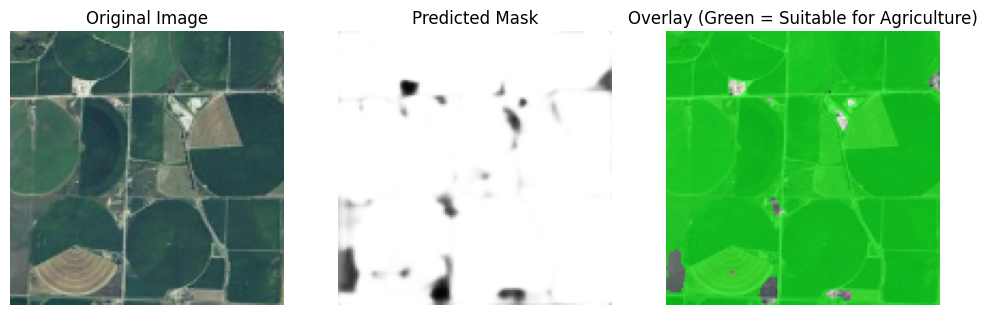

In [ ]:
predict_image("/content/desert_agri_dataset/images/Agriculture_021.jpg")